# Chapter 4. Geocentric Models

In [1]:
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

from jax import lax, vmap
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import hpdi, print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, init_to_value
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

In [3]:

import altair as alt
import janitor

In [4]:
from utils import *

### Code 4.1

In [5]:
# sum along the last dimension (1) 
pos = np.sum(dist.Uniform(-1, 1).sample(PRNGKey(0), (1000, 16)), -1)
pos.shape

(1000,)

## These following code is supposed to demonstrate various "natural" methods for generating a Gaussian dist.

### Code 4.2

In [6]:
np.prod(1 + dist.Uniform(0, 0.1).sample(PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

### Code 4.3

In [7]:
growth = np.prod(1 + dist.Uniform(0, 0.1).sample(PRNGKey(0), (1000, 12)), -1)
growth.shape

(1000,)

In [8]:
dist.Uniform(0, 1).sample(PRNGKey(0), (5,2))

DeviceArray([[0.35490513, 0.60419905],
             [0.4275843 , 0.23061597],
             [0.32985854, 0.43953657],
             [0.25099766, 0.27730572],
             [0.7678207 , 0.71474564]], dtype=float32)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c423760>],
      dtype=object)

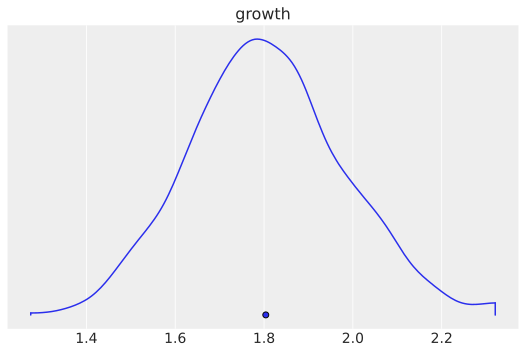

In [9]:
 
az.plot_density({"growth": growth}, credible_interval=1.0)

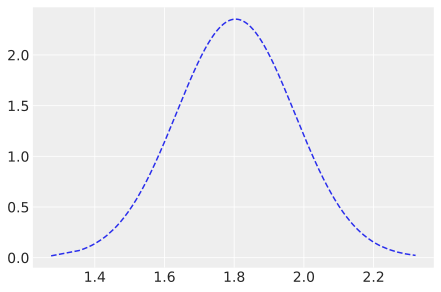

In [10]:
x = np.sort(growth)
plt.plot(x, np.exp(dist.Normal(np.mean(x), np.std(x)).log_prob(x)), "--");

### Code 4.4

In [11]:
# take the product along the last dimension of a 1000 x 12 matrix of uniform random numbers [0,0.5]
big = np.prod(1 + dist.Uniform(0, 0.5).sample(PRNGKey(0), (1000, 12)), -1)

# this is smaller increments eg. Uniform([0,0.1])
# take the product along the last dimension of a 1000 x 12 matrix of uniform random numbers [0,0.1]
small = np.prod(1 + dist.Uniform(0, 0.01).sample(PRNGKey(0), (1000, 12)), -1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x134894850>],
      dtype=object)

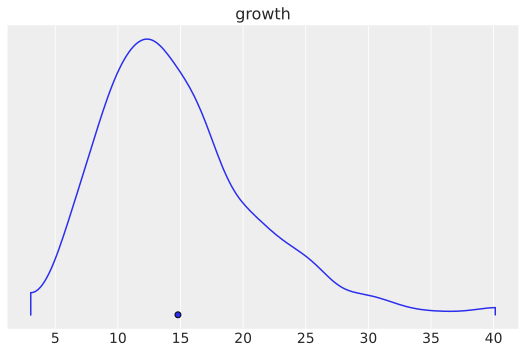

In [12]:

az.plot_density({"growth": big}, credible_interval=1.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x134acd130>],
      dtype=object)

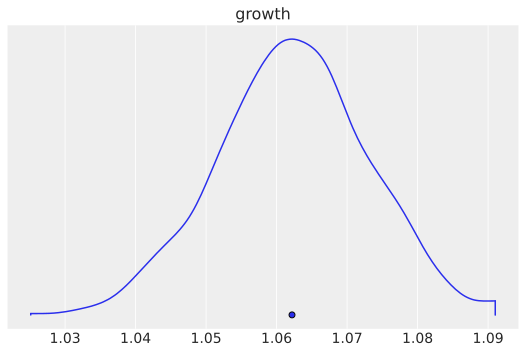

In [13]:

az.plot_density({"growth": small}, credible_interval=1.0)

### Code 4.5

In [14]:
log_big = np.log(np.prod(
    1 + dist.Uniform(0, 0.5).sample(PRNGKey(0), (1000, 12)), -1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x134afcfd0>],
      dtype=object)

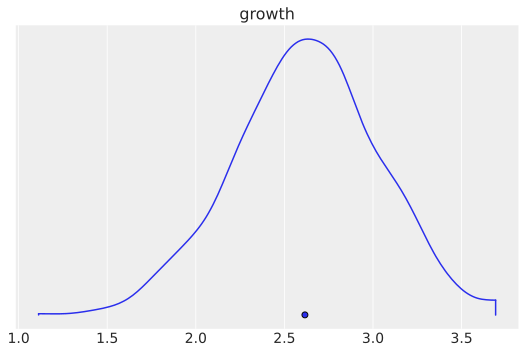

In [15]:

az.plot_density({"growth": log_big}, credible_interval=1.0)

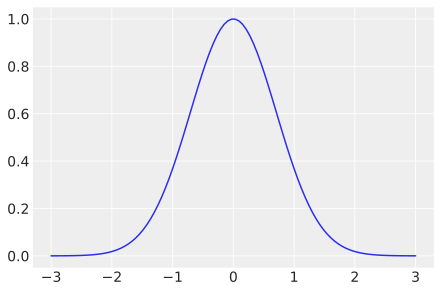

In [16]:
#  Richard's demo of how simple the Gaussian really is
xs = np.linspace(-3,3,100)
plt.plot(xs, np.exp(- xs**2))

### Code 4.6

In [17]:
w = 6; n = 9
p_grid = np.linspace(start=0, stop=1, num=100)
prob_binom = np.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * np.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / np.sum(posterior)

### Code 4.7

In [18]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

### Code 4.8

In [19]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.9

### Code 4.9

In [20]:
# essentially just a way to edit 
dict(zip(d.columns, d.T.values))


{'height': array([151.765 , 139.7   , 136.525 , 156.845 , 145.415 , 163.83  ,
        149.225 , 168.91  , 147.955 , 165.1   , 154.305 , 151.13  ,
        144.78  , 149.9   , 150.495 , 163.195 , 157.48  , 143.9418,
        121.92  , 105.41  ,  86.36  , 161.29  , 156.21  , 129.54  ,
        109.22  , 146.4   , 148.59  , 147.32  , 137.16  , 125.73  ,
        114.3   , 147.955 , 161.925 , 146.05  , 146.05  , 152.7048,
        142.875 , 142.875 , 147.955 , 160.655 , 151.765 , 162.8648,
        171.45  , 147.32  , 147.955 , 144.78  , 121.92  , 128.905 ,
         97.79  , 154.305 , 143.51  , 146.7   , 157.48  , 127.    ,
        110.49  ,  97.79  , 165.735 , 152.4   , 141.605 , 158.8   ,
        155.575 , 164.465 , 151.765 , 161.29  , 154.305 , 145.415 ,
        145.415 , 152.4   , 163.83  , 144.145 , 129.54  , 129.54  ,
        153.67  , 142.875 , 146.05  , 167.005 , 158.4198,  91.44  ,
        165.735 , 149.86  , 147.955 , 137.795 , 154.94  , 160.9598,
        161.925 , 147.955 , 113.665 , 

In [20]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [21]:
j_summary(dict(zip(d.columns, d.T.values)))


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



alt.RepeatChart(...)

### Code 4.10

In [22]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

In [23]:
d2 = d[d.age >= 18]
d2.shape

(352, 4)

### Code 4.12

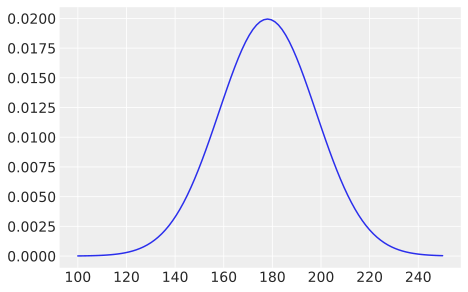

In [24]:
x = np.linspace(100, 250, 101)
plt.plot(x, np.exp(dist.Normal(178, 20).log_prob(x)));

### Code 4.13

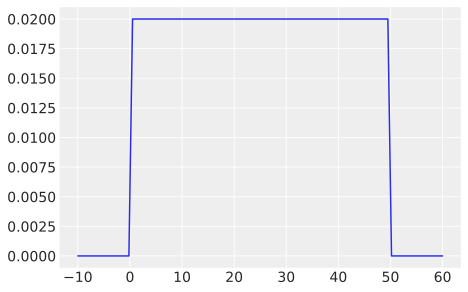

In [25]:
x = np.linspace(-10, 60, 101)
plt.plot(x, np.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)));

### Code 4.14

In [26]:
sample_mu = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu[:100], sample_sigma[:100]).sample(PRNGKey(2))
prior_h.shape

(100,)

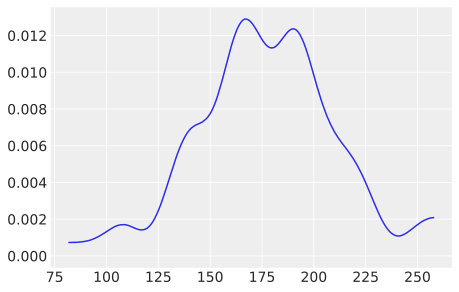

In [27]:
#  reduced the samples and got a more "natural" graph
sample_mu = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu[:100], sample_sigma[:100]).sample(PRNGKey(2))
az.plot_kde(prior_h);

> this is a _prior predictive_. it shows what we expect the posterior to look like before its seen any data.

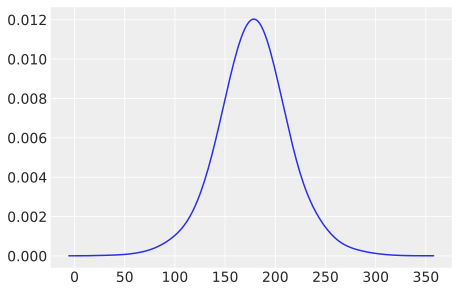

In [28]:
sample_mu = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.15

> same prior but with massive $\sigma$ 

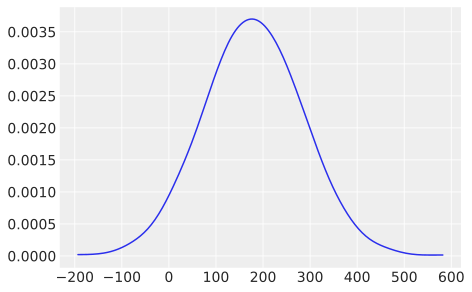

In [29]:
sample_mu = dist.Normal(178, 100).sample(PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.16

In [30]:
# make list of params
# possible states for our model
# the model is that our data can be described by a normal distribution

mu_list = np.linspace(start=150, stop=160, num=100)
sigma_list = np.linspace(start=7, stop=9, num=100)

# make cross product by making two matrices which together simulate a single matrix of pairs
# oh, and then they flatten them
mesh = np.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}

# calculate likelihood of the mu,sigma pairs given the height data
# sum log prob == prod prob
# the prod is over the data, not over the params
post["LL"] = vmap(
        lambda mu, sigma: 
        np.sum(
            dist.Normal(mu, sigma)
            .log_prob(
                d2.height.values))) (post["mu"], post["sigma"])


#  I don't know what this does !! 
#  the prob of post["mu"] under a Normal(178,0) hypothesis
# which is in our case the a priori lprob of mu
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])

#  calculate the unnormalized posterior probabilties  for the mu,sigma pairs (LL(mu,sigm)*)
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = np.exp(post["prob"] - np.max(post["prob"]))


In [31]:
mesh[0].shape, mesh[0].reshape(-1).shape

((100, 100), (10000,))

`vmap` 

### Code 4.17

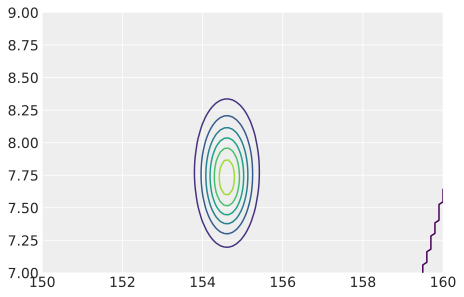

In [32]:
# parameter 1 are the x values (constant along y)
# parameter 2 are the y values (constant along x)
# parameter 3 are the probs for the (x,y) pairs
plt.contour(post["mu"].reshape(100, 100), post["sigma"].reshape(100, 100),
            post["prob"].reshape(100, 100));

### Code 4.18

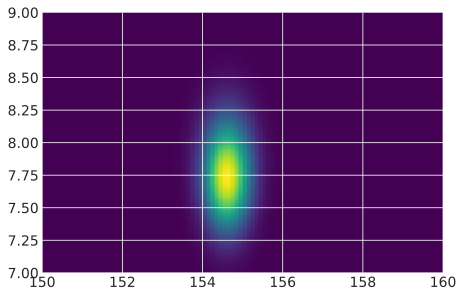

In [33]:
# how do the axis get assigned??
# -> from the extent(..) parameter.
plt.imshow(post["prob"].reshape(100, 100),
           origin="lower", extent=(150, 160, 7, 9), aspect="auto");

### Code 4.19

> so both the plots above are a mapping of (mu, sigma) -> prob(mu, sigma)

but, it is not a sampling of $\mu$ or $\sigma$. it is only a _description_ of the parameters

In [34]:
# we normalize the data here
prob = post["prob"] / np.sum(post["prob"])

# create a "sampling index" here.
sample_rows = dist.Categorical(probs=prob).sample(PRNGKey(0), (int(1e4),))

#  how is this different from above?
# because these are samples from the posterior distribution 
# the posterior dist are the dice that we're going to role - but not the roll itself
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20

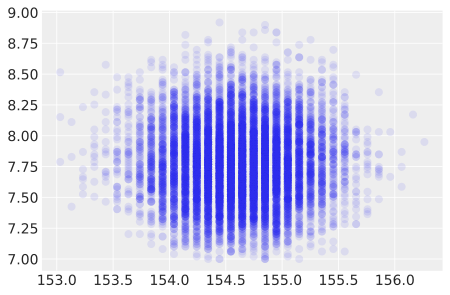

In [35]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none");

### Code 4.19

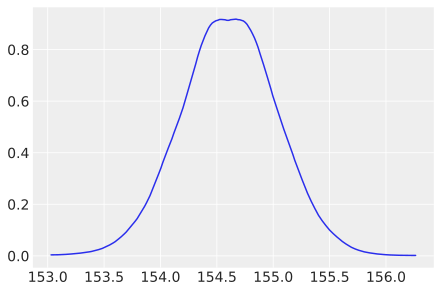

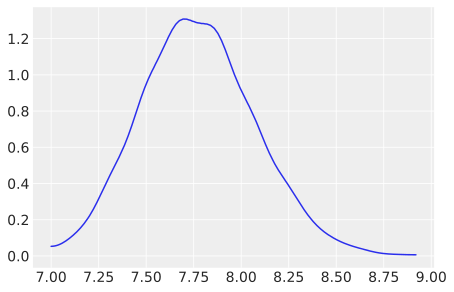

In [36]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma);

### Code 4.22

In [37]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3030305 8.232324 ]


### Code 4.23

In [38]:
d3 = d2.height.sample(n=20)

### Code 4.24

#### Grid Sampling method
This is the whole thing put together in one place.

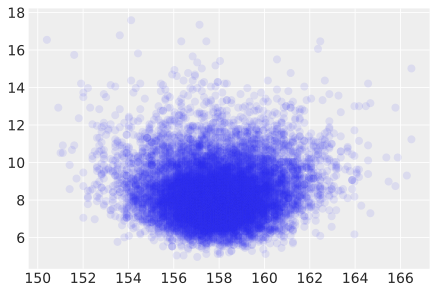

In [39]:
# list of possible mu
mu_list = np.linspace(start=150, stop=170, num=200)

#list of possible sigma
sigma_list = np.linspace(start=4, stop=20, num=200)

# a mesh is a pair of arrays, which simulate a list of pairs
mesh = np.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}

# cool, vmap just takes a func and returns a vectorized version of it 
f_ = vmap(lambda mu, sigma: np.sum( dist.Normal(mu, sigma).log_prob(d3.values)))

# this is the likelihood of the parameters using the data d3.values
# should have shape  (40000) (because we're summing over the dim)
post2["LL"] = f_(post2["mu"], post2["sigma"])

#     dist.Normal(mu, sigma).log_prob(d3.values)))(post2["mu"], post2["sigma"])

# these are the priors for mu and sigma
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])

# post2 is the log posterior prob
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma

# this is a pseudo normalization plus we exp the log prob to be a normal prob
post2["prob"] = np.exp(post2["prob"] - np.max(post2["prob"]))

# then we normalize
prob = post2["prob"] / np.sum(post2["prob"])

# create an index based on the probabilities in prob
sample2_rows = dist.Categorical(probs=prob).sample(PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none");

In [40]:
base = alt.Chart(pd.DataFrame({'mu': sample2_mu, 'sigma': sample2_sigma}).sample(5000))

scatter = base.mark_circle(size=30,opacity=0.1).encode(
    x = alt.X(field='mu', type='quantitative', scale=alt.Scale(zero=False)),
    y = alt.Y(field='sigma', type='quantitative', scale=alt.Scale(zero=False)),
    )

hist = base.mark_bar().encode(
    x = alt.X( aggregate='count', field='mu', type='quantitative', scale=alt.Scale(zero=False)),
    y = alt.Y(bin=alt.Bin(maxbins=20), field='sigma', type='quantitative', scale=alt.Scale(zero=False)),
    ).properties(width=100)


density = base.transform_density(
    'sigma',
    as_=['sigma', 'density'],
).mark_area(orient="horizontal").encode(
    y="sigma:Q",
    x='density:Q',
).properties(width=100)

scatter | hist | density

alt.HConcatChart(...)

In [41]:
post2["mu"].shape, post2["sigma"].shape, post2["LL"].shape

((40000,), (40000,), (40000,))

### Code 4.25

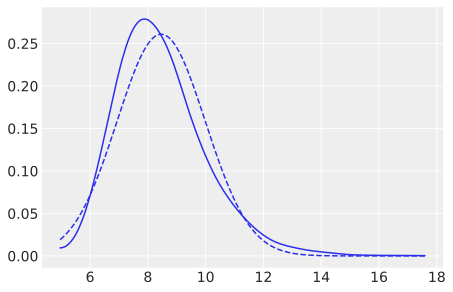

In [42]:
az.plot_kde(sample2_sigma)
x = np.sort(sample2_sigma)
plt.plot(x, np.exp(dist.Normal(np.mean(x), np.std(x)).log_prob(x)), "--");

## The Howell Dataset

### Code 4.26

In [43]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

### Code 4.27

In [44]:
#  our model will attempt to describe the heights of the population
# the prior on mu is N(178,20)
# the prior on sigma is uniform (0,50)
# we have three sample sites in this model (what did we have before?)

# well.. .actually we didn't have any 'model', we had a bunch of mu to which we assigned some probs with N(178,20)
# ditto for the sigma except it was U(0,50)
# then, regardless of the prior distribution, we evaluate the likelihood of all possible (mu,sigma) relative to the given data

# but here, we're throwing them all together into a model.
# we give them names eg. height 
# and the whole thing is a function of the data.

def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.28

In [45]:
# don't know what AutoLaplaceApproximation does 
m4_1 = AutoLaplaceApproximation(flist)

# SVI is stochastic variable inference - this somehowe finds the best parameters for the model.
# optim.Adam(1) for adjusting the jump?
# AutoContinuousELBO() is the error func
# and we give _both_ flist and m4_1 ...
svi = SVI(flist, m4_1, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)

init_state = svi.init(PRNGKey(0))
# scan ??
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))

# p4_1 will return a dict with the mu and  something (not sigma..)
p4_1 = svi.get_params(state)

In [46]:
# don't know what the second number is for... something to do with sigma??
p4_1

{'auto_loc': DeviceArray([154.60706  ,  -1.6973906], dtype=float32)}

### Code 4.29

> these results should almost identical to the previous grid results _except_ they are MAP results.

In [47]:
samples = m4_1.sample_posterior(PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



In [48]:
# def j_summary(samples):
#     print_summary(samples, 0.89, False)
#     df = pd.DataFrame(samples).clean_names()
#     df = df if len(df)< 5000 else df.sample(n=4000)
#     base = alt.Chart(df).mark_bar().properties(height=50)

#     return base.encode(
#         alt.X(bin=alt.Bin(maxbins=20), field=alt.repeat("row"), type='quantitative'),
#         y = 'count()'
#     ).repeat(row=[c for c in df.columns])

In [49]:
#  j_summary provides _marginal_ distributions (thus no covariance)
j_summary(samples)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



alt.RepeatChart(...)

### Code 4.30

In [50]:
# d2 is the height for those over 18

# we adjust things by priming AutoLaplaceApprox with some values, didn't do that last time 
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_strategy=init_to_value(start))
svi = SVI(flist, m4_1, optim.Adam(0.1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p4_1 = svi.get_params(state)

In [51]:
p4_1

{'auto_loc': DeviceArray([154.60928  ,  -1.6973298], dtype=float32)}

### Code 4.31

We give $\mu$ a very tight prior, leaving $\sigma$ the same. 

The result is that $\mu$ is constrained so the model compensates by ascribing a large $\sigma$

In [52]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p4_2 = svi.get_params(state)
samples = m4_2.sample_posterior(PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



### Code 4.32

this is a little different from the book, I think. 

In the book vcov takes a fitted model and spits out the covariance matrix. Here, it is calculated fom the sample_posterior.

In [53]:
# get a thousand samples of mu and sigma from the posterior
samples = m4_1.sample_posterior(PRNGKey(1), p4_1, (1000,))
vcov = np.cov(np.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16251372, 0.00172972],
             [0.00172972, 0.08735678]], dtype=float32)

### Code 4.33

We need a refresher on covariance vs. correlation

covariance(a,b) = $ \frac{\sum_i (a_i - \bar{a})(b_i - \bar{b})}{(\sum_i a_i -\bar{a})(\sum_i b_i - \bar{b})} $

correlation(a,b

In [54]:
# this is correlation (as opposed to covariance)
print(np.diagonal(vcov))

# what does np.outer do?
# what every outer product does...
print(vcov / np.sqrt(np.outer(np.diagonal(vcov), np.diagonal(vcov))))

# looks like covariance is very small (eg. noise?)
# so, yes there's nominal interaction between the variables but is this a function
# of the data, or of the method for extracting the parameters from the posterior

[0.16251372 0.08735678]
[[1.         0.01451718]
 [0.01451718 1.        ]]


### Code 4.34

In [55]:
# from previous thang. don't see any difference between post and samples
#  and nor should I, I believe "samples" was created using the grid method. 
# whereas post is created using SVI (our quap)
# samples = m4_2.sample_posterior(PRNGKey(1), p4_2, (1000,))
post = m4_1.sample_posterior(PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [154.24428, 154.48541, 154.97919, 154.2124, 155.49146, 154.82701],
 'sigma': [7.560233, 7.3066654, 7.280367, 7.811781, 7.905633, 7.978665]}

### Code 4.35

In [56]:
# attempts to make a perfect mini-histogram ...
_df = pd.DataFrame(post).clean_names()
_df.bin_numeric('mu', 'mu_bin').transform_column('mu_bin', lambda x: x.left)

mu     sigma   mu_bin
0     154.244278  7.560233  153.749
1     154.485413  7.306665  154.381
2     154.979187  7.280367  154.381
3     154.212402  7.811781  153.749
4     155.491455  7.905633  155.012
...          ...       ...      ...
9995  154.669144  7.460491  154.381
9996  155.416580  7.794899  155.012
9997  154.648651  7.636652  154.381
9998  154.354401  7.435292  153.749
9999  154.068695  7.653482  153.749

[10000 rows x 3 columns]

In [57]:
# just trying to get a historgram out of pandas
_df = pd.DataFrame(post).clean_names()
# _s = _df.mu.groupby(pd.cut(_df.mu, 10)).count()
_s = pd.cut(_df.mu, 10).value_counts().reset_index()
# pd.DataFrame(_s, index= _s.index.right)
# _s.reset_index().apply(lambda r: r.index, axis=0)
# _s.reset_index().loc[:, ['index']].applymap(lambda x: pd.Series(x.left, x.mu))

# _s.reset_index()
#     y="height:Q")
# _df.vals.value_counts()
_ss = _s.transform_column('index', lambda x: round(x.left,2))
_ss

index    mu
0  154.38  2936
1  154.70  2524
2  154.06  1976
3  155.01  1250
4  153.75   760
5  155.33   328
6  153.43   137
7  155.64    62
8  153.11    18
9  155.96     9

In [58]:
alt.Chart(_ss).mark_bar().encode(
x='index:O',
y='mu:Q').properties(height=30)

alt.Chart(...)

In [59]:
# these are marginal distribution of mu and sigma
# print_summary(post, 0.89, False)
j_summary(post)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.61      0.41    154.61    153.93    155.25   9927.00      1.00
     sigma      7.75      0.29      7.74      7.28      8.22   9502.46      1.00



alt.RepeatChart(...)

### Code 4.36

In [60]:
samples_flat = np.stack(list(post.values()))
# remember sigma is a matrix here
mu, sigma = np.mean(samples_flat), np.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(PRNGKey(0), (int(1e4),))

### Code 4.37

In [61]:
alt.Chart(d2).mark_point(size=20).encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
)

alt.Chart(...)

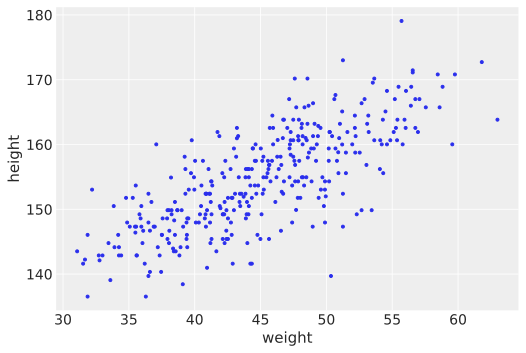

In [62]:
# just a plot of the data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"));

### Code 4.38

In [63]:
# get samples from the prior distribution 
# but not really because the original prior had b\in U(0,50) so this is something else.
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20), sample_shape=(N,))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(N,))

### Code 4.39

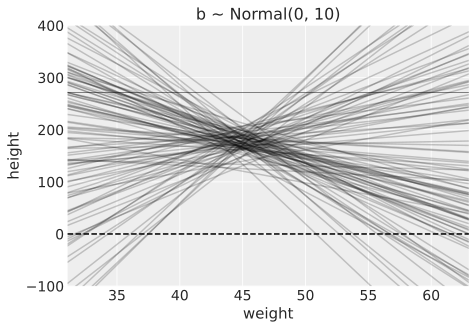

In [64]:
plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);

In [65]:
from altair import datum, expr
xs = np.linspace(d2.weight.min(), d2.weight.max(), 101) 
xbar = d2.weight.mean()

rules_df = pd.DataFrame({'y':[0,272]})

def line_chart(a,b): 
    return alt.Chart(pd.DataFrame({'x':xs, 'y': a + b*(xs-xbar)})).mark_line(width=1, opacity=0.2, clip=True).encode(
    alt.X('x:Q' ),
    alt.Y ('y:Q', scale=alt.Scale(domain=(-100,400))))

glist = [line_chart(a,b) for a,b in zip(a,b)]

rule1 = alt.Chart(rules_df).mark_rule(color='red').encode(
    y = 'y:Q'
)

alt.layer(*glist, rule1).properties(width=600) #+ rule1 + rule2

alt.LayerChart(...)

### Code 4.40

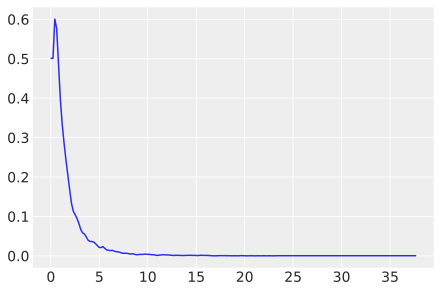

In [66]:
b = dist.LogNormal(0, 1).sample(PRNGKey(0), (int(1e4),))
az.plot_kde(b, bw=0.5);

In [67]:
alt.Chart(pd.DataFrame({'b':b}).sample(5000)).mark_line().transform_density(
    'b',
    as_=['b', 'density']
).encode(
    y='density:Q',
    x='b')


alt.Chart(...)

In [68]:
b.max()

DeviceArray(37.63708, dtype=float32)

### Code 4.41

In [69]:
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28), sample_shape=(N,))
    b = numpyro.sample("b", dist.LogNormal(0, 1), sample_shape=(N,))

In [70]:
from altair import datum, expr
xs = np.linspace(d2.weight.min(), d2.weight.max(), 101) 
xbar = d2.weight.mean()

rules_df = pd.DataFrame({'y':[0,272]})

def line_chart(a,b): 
    return alt.Chart(pd.DataFrame({'x':xs, 'y': a + b*(xs-xbar)})).mark_line(width=1, opacity=0.2, clip=True).encode(
    alt.X('x:Q' ),
    alt.Y ('y:Q', scale=alt.Scale(domain=(-100,400))))

glist = [line_chart(a,b) for a,b in zip(a,b)]

rule1 = alt.Chart(rules_df).mark_rule(color='red').encode(
    y = 'y:Q'
)

alt.layer(*glist, rule1).properties(width=600) #+ rule1 + rule2

alt.LayerChart(...)

### Code 4.42

In [71]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - xbar)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_3 = svi.get_params(state)

In [72]:
p4_3

{'auto_loc': DeviceArray([ 1.5460138e+02, -9.9574029e-02, -2.1799510e+00], dtype=float32)}

### Code 4.43

In [73]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + np.exp(log_b) * (weight - xbar)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3b = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3b, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_3b = svi.get_params(state)

In [74]:
p4_3b

{'auto_loc': DeviceArray([ 1.5460138e+02, -9.9574029e-02, -2.1799510e+00], dtype=float32)}

### Code 4.44

In [75]:
samples = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
# print_summary(samples, 0.89, False)
j_summary(samples)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



alt.RepeatChart(...)

### Code 4.45

In [76]:
vcov = np.cov(np.stack(list(samples.values()), axis=0))
np.round(vcov, 3)

DeviceArray([[0.075, 0.   , 0.001],
             [0.   , 0.002, 0.   ],
             [0.001, 0.   , 0.038]], dtype=float32)

### Code 4.46

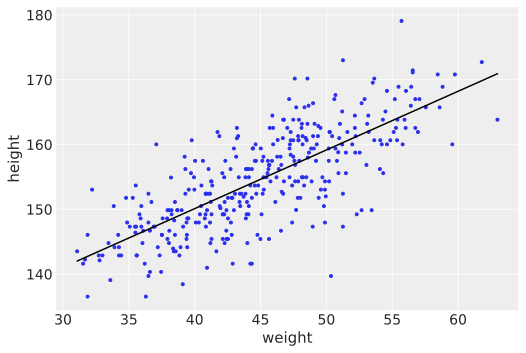

In [77]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
a_map = np.mean(post["a"])
b_map = np.mean(post["b"])
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k");

In [78]:
scatter = alt.Chart(d2).mark_circle().encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
) 

line = alt.Chart(pd.DataFrame({'x': x,'y': a_map+b_map * (x-xbar)})).mark_line().encode(
    x='x:Q',
    y='y:Q')
scatter + line 

alt.LayerChart(...)

### Code 4.47

In [79]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent][:5]) for latent in post}

{'a': [154.36615, 154.78511, 154.73534, 154.53842, 154.53549],
 'b': [0.974645, 0.8900049, 0.8190222, 0.83341044, 1.011918],
 'sigma': [4.976459, 4.943529, 5.2826023, 4.877721, 4.894869]}

### Code 4.48

In [80]:
# we look at the model with very reduced sample size
N = 10
dN = d2[:N]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - np.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

mN = AutoLaplaceApproximation(model)
svi = SVI(model, mN, optim.Adam(1), AutoContinuousELBO(),
          weight=dN.weight.values, height=dN.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
pN = svi.get_params(state)

### Code 4.49

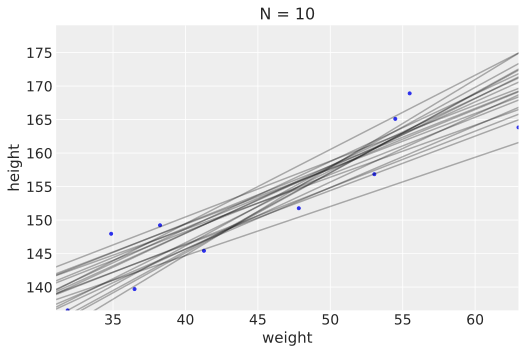

In [81]:
# extract 20 samples from the posterior
post = mN.sample_posterior(PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

In [82]:
scatter = alt.Chart(d2[:40]).mark_circle().encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
) 

def line_chart(a,b): 
    return alt.Chart(pd.DataFrame({'x':xs, 'y': a + b*(xs-xbar)})).mark_line(width=1, opacity=0.1, clip=True).encode(
    alt.X('x:Q' ),
    alt.Y ('y:Q')) # 

glist = [line_chart(a,b) for a,b in zip(post['a'],post['b'])]

scatter + alt.layer(*glist).properties(width=800)

alt.LayerChart(...)

### Code 4.50

In [83]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

j_summary({'mu50': mu_at_50})


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      mu50    159.16      0.35    159.15    158.66    159.75    985.14      1.00



alt.RepeatChart(...)

### Code 4.51

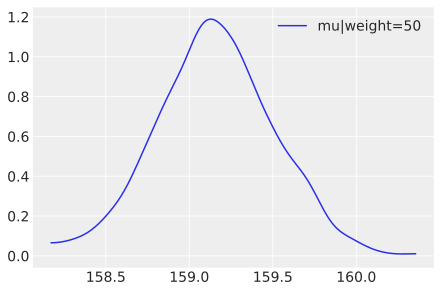

In [84]:
az.plot_kde(mu_at_50, label="mu|weight=50");

### Code 4.52

In [85]:
np.percentile(mu_at_50, q=(5.5, 94.5))

DeviceArray([158.5957 , 159.71445], dtype=float32)

### Code 4.53

In [86]:
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), d2.weight.values, d2.height.values)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352), [157.12938, 157.30838, 157.05736, 156.90125, 157.4044])

### Code 4.54

In [87]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = np.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), weight_seq, None)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46), [134.88252, 136.99348, 138.36269, 137.87814, 134.30676])

### Code 4.55

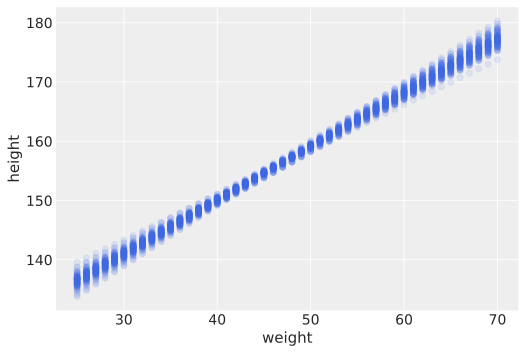

In [88]:
# plotting mu as a function of weight


# use plot_kwargs={"alpha": 0} to hide raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0})

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

In [89]:
# alt.Chart()
_df = pd.DataFrame(mu.T[:,:100], index=weight_seq, columns=range(100)).stack()
# _df.reset_index(level=1, name="height" )
c_df = _df.reset_index( name="height" ).rename({'level_0':'weight','level_1':'line'}, axis=1)

In [90]:
alt.Chart(c_df).mark_circle(size=60, opacity=0.2).encode(
    x=alt.X("weight:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("height:Q", scale=alt.Scale(zero=False), title = 'mu_height(weight)'),
    color=alt.Color("line:O", legend=None)
)

alt.Chart(...)

In [92]:
alt.Chart(c_df).mark_line(opacity=0.2).encode(
    x=alt.X("weight:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("height:Q", scale=alt.Scale(zero=False)),
    color= alt.Color("line:O", legend=None)
)

alt.Chart(...)

### Code 4.56

In [93]:
# summarize the distribution of mu
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

### Code 4.57

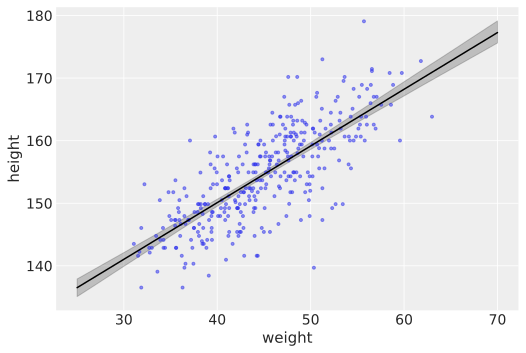

In [94]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

In [95]:
scatter = alt.Chart(d2).mark_point(size=20).encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
)

mean_line = alt.Chart(pd.DataFrame({'weight': weight_seq, 'mu': mu_mean})).mark_line(color='black').encode(
    x = 'weight:Q',
    y = 'mu'
    )

area = alt.Chart(pd.DataFrame({'weight': weight_seq, 'area_l': mu_PI[0], 'area_h':mu_PI[1]})).mark_area(opacity=0.4).encode(
    x='weight:Q',
    y='area_l:Q',
    y2='area_h:Q')
(scatter + mean_line + area).properties(width=800)

alt.LayerChart(...)

### Code 4.58

In [96]:
#  get posterior samples for a,b, sigma
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))

# func for calculatig mu_height
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)

# weight values we want to calculate height for 
weight_seq = np.arange(start=25, stop=71, step=1)

# the mu values for height
mu = vmap(mu_link)(weight_seq).T

# the mean mu values for each weight
mu_mean = np.mean(mu, 0)

# the lo and hi values for mu (shape is 2,46)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59

In [97]:
post.keys(), post['a'].shape

(dict_keys(['a', 'b', 'sigma']), (1000,))

In [98]:
# Predictive returns a dictionary (possibly with the keys from return_sites)
# basically we use the the samples in post, and our original model to get new values for height
# (why would they be different than the original height data?  because we modeled them as a function of
# weight and now we're feeding in different weight values AND even if we didn't its still returning a
# distribution)

sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    PRNGKey(2), weight_seq, None)["height"] # <<- weight_seq
sim_height.shape, list(sim_height[:5, 0])

((1000, 46), [141.32513, 139.48373, 138.27194, 138.07433, 130.40279])

In [99]:
Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    PRNGKey(2), weight_seq, None)

{'height': DeviceArray([[141.32513 , 128.24945 , 138.27396 , ..., 171.22151 ,
               179.5985  , 170.57654 ],
              [139.48373 , 140.47516 , 136.1823  , ..., 172.709   ,
               180.70943 , 169.47899 ],
              [138.27194 , 137.48203 , 145.62218 , ..., 171.46323 ,
               177.64203 , 172.54236 ],
              ...,
              [141.66032 , 121.400215, 136.92128 , ..., 175.67995 ,
               171.51309 , 179.78278 ],
              [131.88843 , 136.61806 , 137.77335 , ..., 177.12476 ,
               172.41487 , 170.1224  ],
              [134.7667  , 135.4647  , 143.44289 , ..., 177.00125 ,
               171.80734 , 175.17137 ]], dtype=float32)}

### Code 4.60

In [100]:
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.61

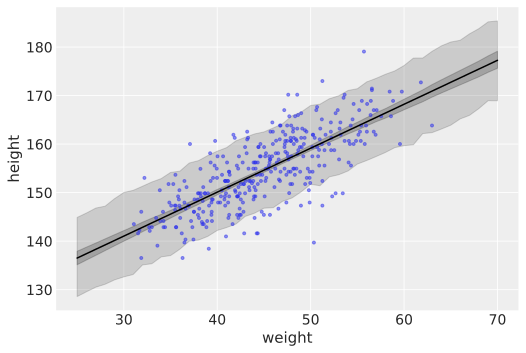

In [101]:
# plot raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

In [102]:
scatter = alt.Chart(d2).mark_point(size=20).encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
)

mean_line = alt.Chart(pd.DataFrame({'weight': weight_seq, 'mu': mu_mean})).mark_line(color='black').encode(
    x = 'weight:Q',
    y = 'mu'
    )

mu_area = alt.Chart(pd.DataFrame({'weight': weight_seq, 'area_l': mu_PI[0], 'area_h':mu_PI[1]})).mark_area(opacity=0.4).encode(
    x='weight:Q',
    y='area_l:Q',
    y2='area_h:Q')

height_area = (alt
    .Chart(pd.DataFrame( {'weight': weight_seq, 'w0': height_PI[0],  'w1': height_PI[1]}))
    .mark_area(opacity=0.2,)
    .encode( x='weight:Q', y='w0:Q', y2='w1:Q')
)



(scatter + mean_line + area + height_area).properties(width=800)

alt.LayerChart(...)

### Code 4.62

In [129]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, sample_shape=(int(1e4),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    PRNGKey(2), weight_seq, None)["height"]
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

print(f'sim_height shape: {sim_height.shape}')
print(f'height_PI shape: {height_PI.shape}')

height_PI[:,:5]

sim_height shape: (10000, 46)
height_PI shape: (2, 46)


DeviceArray([[128.18105, 129.37335, 130.2029 , 130.77896, 131.83902],
             [144.64366, 145.5002 , 146.59335, 147.28516, 148.31726]],            dtype=float32)

### Code 4.63

In [141]:
# get posterior distributions using  1000 samples
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
weight_seq = np.arange(25, 71)
# so what is different here??
# 
# for each posterior, sample a height for each weight (should be a line, no?)
# again, why is there no sigma??
# because it should have been there. yeah.
sim_height = vmap(lambda i, weight:
                  # why is there no sigma in here??
                  dist.Normal(post["a"] + post["b"] * (weight - xbar), post["sigma"])
                  .sample(PRNGKey(i))
                 ) (
    np.arange(len(weight_seq)), 
    weight_seq
)
print(f'sim_height shape: {sim_height.shape}')
print(f'height_PI shape: {height_PI.shape}')

sim_height shape: (46, 1000)
height_PI shape: (2, 46)


In [142]:
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=1)

height_PI[:,:5], height_PI.shape

(DeviceArray([[128.51714, 128.93176, 129.87407, 131.03271, 131.91759],
              [144.52873, 144.86954, 146.67195, 147.18083, 148.57222]],            dtype=float32),
 (2, 46))

In [143]:
scatter = alt.Chart(d2).mark_point(size=20).encode(
    alt.X("weight:Q", scale=alt.Scale(zero=False)),
    alt.Y("height:Q", scale=alt.Scale(zero=False)),
)
scatter

alt.Chart(...)

In [144]:
mean_line = alt.Chart(pd.DataFrame({'weight': weight_seq, 'mu': mu_mean})).mark_line(color='black').encode(
    x = 'weight:Q',
    y = 'mu'
    )
mean_line

alt.Chart(...)

In [145]:
mu_area = alt.Chart(pd.DataFrame({'weight': weight_seq, 'area_l': mu_PI[0], 'area_h':mu_PI[1]})).mark_area(opacity=0.4).encode(
    x='weight:Q',
    y='area_l:Q',
    y2='area_h:Q')
mu_area

alt.Chart(...)

In [146]:
weight_seq.shape, height_PI.shape

((46,), (2, 46))

In [147]:
height_area = (alt
    .Chart(pd.DataFrame( {'weight': weight_seq, 'w0': height_PI[0],  'w1': height_PI[1]}))
    .mark_area(opacity=0.2,)
    .encode( x='weight:Q', y='w0:Q', y2='w1:Q')
)
height_area

alt.Chart(...)

In [148]:
(scatter + mean_line + area + height_area).properties(width=800)

alt.LayerChart(...)

### Code 4.64

In [ ]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

### Code 4.65

In [ ]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2

def model(weight_s, weight_s2, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_5, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_5 = svi.get_params(state)

### Code 4.66

In [ ]:
samples = m4_5.sample_posterior(PRNGKey(1), p4_5, (1000,))
print_summary(samples, 0.89, False)

### Code 4.67

In [ ]:
weight_seq = np.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2,
            "height": None}
post = m4_5.sample_posterior(PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post, return_sites=["mu", "height"])
mu = predictive.get_samples(PRNGKey(2), **pred_dat)["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive.get_samples(PRNGKey(2), **pred_dat)["height"]
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.68

In [ ]:
az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

### Code 4.69

In [ ]:
d["weight_s3"] = d.weight_s ** 3

def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_6, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          weight_s3=d.weight_s3.values, height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_6 = svi.get_params(state)

### Code 4.70

In [ ]:
ax = az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
                  plot_kwargs={"alpha": 0.5})
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

### Code 4.71

In [ ]:
at = np.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### Code 4.72

In [ ]:
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)

### Code 4.73

In [ ]:
d2 = d[d.temp.notna()]  # not NaN cases on temp
num_knots = 15
knot_list = np.quantile(d2.year.values.astype(float),
                        q=np.linspace(0, 1, num=num_knots))

### Code 4.74

In [ ]:
knots = onp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

In [ ]:
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(0, 1),
            xlabel="year", ylabel="basis value")
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

### Code 4.76

In [ ]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + B @ w
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": np.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_7 = svi.get_params(state)

### Code 4.77

In [ ]:
post = m4_7.sample_posterior(PRNGKey(1), p4_7, (1000,))
w = np.mean(post["w"], 0)
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(-2, 2),
            xlabel="year", ylabel="basis * weight")
for i in range(B.shape[1]):
    plt.plot(d2.year, w[i] * B[:, i], "k", alpha=0.5)

### Code 4.78

In [ ]:
mu = Predictive(m4_7.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), B, None)["mu"]
mu_PI = np.percentile(mu, q=(1.5, 98.5), axis=0)
az.plot_pair(d2[["year", "temp"]].astype(float).to_dict(orient="list"),
             plot_kwargs={"c": "royalblue", "alpha": 0.3})
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5);

### Code 4.79

In [ ]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + np.sum(B * w, axis=-1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": np.zeros(B.shape[1])}
m4_7alt = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7alt, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_7alt = svi.get_params(state)

### Code 4.80

In [ ]:
az.plot_pair(Howell1[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.4});